In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
from glob import glob
from pathlib import Path

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
filenames = glob(f'/kaggle/working/*.*')
for filename in filenames:
    print(filename)
    if 'scores.logs' in filename:
        continue
#     Path(filename).unlink()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ozon-task-five/preprocess_test_pairs_wo_target.pkl
/kaggle/input/ozon-task-five/preprocess_train_pairs.pkl
/kaggle/input/ozon-task-five/dts_object.pkl
/kaggle/input/ozon-task-five/test_pairs_wo_target.pkl
/kaggle/input/ozon-task-five/scores.logs
/kaggle/input/ozon-task-five/train_pairs.pkl
/kaggle/input/ozon-task-five/preprocess_data.pkl
/kaggle/working/__notebook_source__.ipynb


In [2]:
PARQUET_ENGINE = 'pyarrow'
DATASET_PATH = Path('/kaggle/input/ozon-task-five')
WORK_PATH = Path('.')
PREDICTIONS_DIR = Path('.')

In [3]:
import re
import numpy as np
import pandas as pd
import pickle

from pathlib import Path
from datetime import date, datetime, timedelta
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.integration import CatBoostPruningCallback

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import precision_recall_curve, auc

from time import time

__import__("warnings").filterwarnings('ignore')


def convert_seconds(time_apply):
    # print(type(time_apply), time_apply)
    try:
        time_apply = float(time_apply)
    except ValueError:
        time_apply = 0
    if isinstance(time_apply, (int, float)):
        hrs = time_apply // 3600
        mns = time_apply % 3600
        sec = mns % 60
        time_string = ''
        if hrs:
            time_string = f'{hrs:.0f} час '
        if mns // 60 or hrs:
            time_string += f'{mns // 60:.0f} мин '
        return f'{time_string}{sec:.1f} сек'


def print_time(time_start):
    """
    Печать времени выполнения процесса
    :param time_start: время запуска в формате time.time()
    :return:
    """
    time_apply = time() - time_start
    print(f'Время обработки: {convert_seconds(time_apply)}')


def print_msg(msg):
    print(msg)
    return time()


def memory_compression(df, use_category=True, use_float=True):
    """
    Изменение типов данных для экономии памяти
    :param df: исходный ДФ
    :param use_category: преобразовывать строки в категорию
    :param use_float: преобразовывать float в пониженную размерность
    :return: сжатый ДФ
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        # print(f'{col} тип: {df[col].dtype}', str(df[col].dtype)[:4])

        if str(df[col].dtype)[:4] in 'datetime':
            continue

        elif str(df[col].dtype) not in ('object', 'category'):
            col_min = df[col].min()
            col_max = df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and \
                        col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and \
                        col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and \
                        col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif col_min > np.iinfo(np.int64).min and \
                        col_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif use_float and str(df[col].dtype)[:5] == 'float':
                if col_min > np.finfo(np.float16).min and \
                        col_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif col_min > np.finfo(np.float32).min and \
                        col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

        elif use_category and str(df[col].dtype) == 'object':
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f'Исходный размер датасета в памяти '
          f'равен {round(start_mem, 2)} мб.')
    print(f'Конечный размер датасета в памяти '
          f'равен {round(end_mem, 2)} мб.')
    print(f'Экономия памяти = {(1 - end_mem / start_mem):.1%}')
    return df

In [4]:
!pip install pymorphy2
!pip install pytils
!pip install transliterate 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 54.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pytils: filename=pytils-0.4.1-py3-none-any.whl size=32538 sha256=1bfce9bf48cf2ac79d516e8cb4c5a45bec9ad024e92218fd86b5ec408abd1fd2
  Stored in directory: /root/.cache/pip/wheels/5a/eb/7c/3b6f0c25815749883152b2caca34c35dbaab13ec2864270cbd
Successfully built pytils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.3 MB/s eta 0:00:00


In [5]:
from ast import literal_eval
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

import spacy
import pymorphy2

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from pytils.translit import translify, detranslify
from transliterate import translit
from fuzzywuzzy import fuzz

from fasttext.FastText import _FastText

In [6]:
class TextLemmatization:
    def __init__(self):
        model_file = DATASET_PATH.joinpath('lid.176.bin')
        if not model_file.is_file():
            model_file = r'D:\python-txt\my_addons\lid.176.ftz'
        self.ft_model = _FastText(model_path=str(model_file))
        self.snowball_ru = SnowballStemmer(language='russian')
        self.snowball_en = SnowballStemmer(language='english')
        self.morphatizer = pymorphy2.MorphAnalyzer()
        self.lemmatizer = WordNetLemmatizer()
        self.ru_en_stop = set(stopwords.words('russian') + stopwords.words('english'))
        self.pattern_date = r'[0-9_\.\/\\-]+'
        self.pattern_punct = r'[!@"“’«»#$%&\'()*+,—/:;<=>?^_`{|}~\[\]]'
        self.digits = ''.join(str(i) for i in range(10))
        self.nlp_ru = spacy.load("ru_core_news_sm")
        self.nlp_en = spacy.load("en_core_web_sm")
        self.text_language = 'russian'
        self.use_unique_words = True
        self.singular = ('bes', 'bez', 'bolee', 'budet', 'da', 'do', 'dva', 'ee', 'ego',
                         'emu', 'esli', 'gde', 'i', 'ih', 'ili', 'iz', 'k', 'kak', 'ko',
                         'kogda', 'kto', 'li', 'mne', 'mnogo', 'na', 'nad', 'nado', 'nas',
                         'ne', 'nego', 'ni', 'nim', 'nu', 'o', 'ob', 'oba', 'odin', 'ona',
                         'oni', 'ot', 'pered', 'po', 'pod', 'potom', 'potomu', 'pri', 'pro',
                         'raz', 's', 'sebe', 'tak', 'tam', 'tem', 'togda', 'tri', 'tut',
                         'u', 'v', 'vam', 'vas', 'vdrug', 'vid', 'vo', 'vot', 'vse',
                         'vsegda', 'vsego', 'za', 'zatem')

    def identification_language(self, text):
        """
        Определение языка текста и запись его в переменную self.text_language
        :param text: текст
        :return: код языка
        """
        predict_lang = self.ft_model.predict(text)
        print('predict_lang', predict_lang)
        detect_language = {'en': 'english'}.get(predict_lang[0][0][-2:], 'russian')

        # тут определение, что это транслитерация
        if self.detect_translit(text):
            detect_language = 'transliteration'

        self.text_language = detect_language
        print('Определен язык:', detect_language)
        return detect_language

    @staticmethod
    def del_empty_lines(text):
        """
        Удаление пустых строк
        :param text: текст
        :return: очищенный текст
        """
        text = re.sub('\ufeff', '', str(text))
        # разделение на строки
        text_list = re.split(r'\n', text)
        # склейка обратно в строку, только без пустых строк
        text = '\n'.join(s.strip() for s in text_list if s.strip())
        return text.strip()

    def preprocess(self, tokens):
        """
        В функции отфильтруем также числа, проверив первый символ.
        Так, это поможет избавиться от «2019», но не от Covid-19.
        :param tokens: список слов
        :return: список нормализованных слов
        """
        return [self.morphatizer.parse(word)[0].normal_form for word in tokens if
                (word[0] not in self.digits and word not in self.ru_en_stop)]

    def normalize_text(self, input_text, language=None, unique_words=None):
        """
        Перевод текста в нижний регистр, удаление дат, удаление знаков пунктуации
        деление текста на слова
        :param input_text: текст
        :param language: язык текста
        :param unique_words: оставляем только уникальные слова
        :return: список слов
        """
        if language is None:
            language = self.text_language
        if unique_words is None:
            unique_words = self.use_unique_words

        # убираем из текста цифры и переводим в нижний регистр
        # input_text = re.sub(self.pattern_date, ' ', str(input_text).lower())

        # убираем из текста знаки пунктуации
        input_text = re.sub(self.pattern_punct, ' ', input_text.lower())

        # если язык = 'transliteration'
        if language == 'transliteration':
            language = 'russian'
            self.text_language = language
            trans = input_text
            # вариант детранслитерации № 1
            input_text = detranslify(trans)
            # print('Вариант 1:', input_text)
            # # вариант детранслитерации № 2
            # input_text = translit(trans, 'ru')
            # print('Вариант 2:', input_text)

        words = word_tokenize(input_text, language=language)
        out_words = []
        for word in words:
            # пропускаем буквенные слова из одной буквы, цифры оставляем
            if len(word) == 1 and word.isalpha():
                continue
            # если собираем только уникальные слова
            if unique_words and word in out_words:
                continue
            if word not in self.ru_en_stop:
                out_words.append(word)

        return out_words

    def stem_text(self, list_words, language=None, unique_words=None):
        if language is None:
            language = self.text_language
        if unique_words is None:
            unique_words = self.use_unique_words

        snowball = self.snowball_ru if language == 'russian' else self.snowball_en
        stem_words = []
        for word in list_words:
            stem_word = snowball.stem(word)
            if stem_word not in self.ru_en_stop and (
                    not unique_words or (unique_words and stem_word not in stem_words)):
                stem_words.append(stem_word)
        return stem_words

    def lemm_text(self, list_words, language=None, unique_words=None):
        """
        Лемматизация текста
        :param list_words: список слов
        :param language: язык
        :param unique_words: возвращать только уникальные слова
        :return: список словарных лемм, список топонимов, список имен персон
        """
        if language is None:
            language = self.text_language
        if unique_words is None:
            unique_words = self.use_unique_words

        lemm_words = []

        for word in list_words:
            parsed = self.morphatizer.parse(word)[0]
            # print(parsed.normal_form, parsed.tag)
            if language == 'russian':
                lemma = parsed.normal_form
                if lemma not in self.ru_en_stop and (
                        not unique_words or (unique_words and lemma not in lemm_words)):
                    lemm_words.append(lemma)
            else:
                # получим токен из словаря, если его нет (такое возможно для составных слов)
                # --> возьмем первой токен из токенизированного одного слова
                lemma = self.lemmatizer.lemmatize(word).lower()
                if lemma not in self.ru_en_stop and (
                        not unique_words or (unique_words and lemma not in lemm_words)):
                    lemm_words.append(lemma)

        return lemm_words

    def make_sentences(self, text):
        """
        Разделение текста на предложения
        :param text: текст
        :return: список предложений
        """
        return sent_tokenize(self.del_empty_lines(text))

    def detect_translit(self, text):
        """
        Определение является ли текст транслитерацией
        :param text: текст
        :return: True|False - транлитерация или нет
        """
        # убираем из текста знаки пунктуации
        _text = re.sub(self.pattern_punct, ' ', text.lower())
        # делим на слова и формируем список коротких слов
        small_words = [*filter(lambda x: len(x) < 4 and x.isalpha(), word_tokenize(_text))]
        # выделяем из текста однозначно транслитерированные короткие русские слова
        trans_words = re.findall(fr"\W({'|'.join(self.singular)})\W", text, flags=re.I)
        # количество trans_words составляет больше половины small_words - это транслитерация
        # print(len(trans_words), len(small_words))
        return len(trans_words) >= len(small_words) * 0.5


class DataPreprocess:
    def __init__(self):
        self.staples = {'{': '}', '[': ']'}
        self.categories = None
        self.columns = {'color_parsed': 'color',
                        'pic_embeddings_resnet_v1': 'pic_emb',
                        'main_pic_embeddings_resnet_v1': 'main_pic',
                        'name_bert_64': 'name_bert',
                        'characteristic_attributes_mapping': 'ch_att_map'}

    @staticmethod
    def make_sample(df, pairs, rows=500):
        """
        Для опытов оставим небольшой сэмпл из данных и виде первых строк
        :param df: ДФ
        :param rows: количество строк ДФ
        :return: ДФ сэмпла данных
        """
        pair = pairs.iloc[:rows]
        idxs = set(pair.variantid1.to_list() + pair.variantid2.to_list())
        if 'variantid' in df.columns:
            df = df[df.variantid.isin(idxs)]
        return df, pair

    def item_from_text(self, cell_text):
        value = np.NaN
        if not pd.isna(cell_text):
            cell_text = cell_text.strip()
            ch_fst = cell_text[0]
            ch_lst = cell_text[-1]
            # открывающая и закрывающая скобки должны быть и быть одинаковыми
            if ch_fst in self.staples.keys() and ch_lst == self.staples[ch_fst]:
                value = literal_eval(cell_text)
        return value

    @staticmethod
    def str_from_dict_values(items):
        """
        Пробразование значений словаря в строку слов, разделенных пробелами
        :param items: словарь
        :return: строка из отсортированных слов
        """
        flatten_str = []
        [flatten_str.extend(item) for item in items.values()]
        return ' '.join(s for s in map(str.lower, map(str.strip, flatten_str))
                        if not s.startswith('http'))

    def fit(self, df):
        """
        Формирование фич
        :param df: исходный ФД
        :return: обработанный ДФ
        """
        self.categories = {cat: f'cat_{idx}' for idx, cat in
                           enumerate(sorted(set(df['categories'].unique())), 1)}
        return df

    @staticmethod
    def mean_pic_embeddings(pic_embeddings):
        """
        Формирование усредненного ембендинга дополнительных картинок
        :param pic_embeddings: массив с ембендингами
        :return: усредненный ембендинг
        """
        if pic_embeddings.shape[0] > 1 and len(pic_embeddings.shape) > 1:
            return np.mean(pic_embeddings, axis=0)
        elif pic_embeddings.shape[0] == 128:
            return pic_embeddings
        return pic_embeddings[0]

    def transform(self, df, model_columns=None):
        """
        Формирование остальных фич
        :param df: ДФ
        :param model_columns: список колонок, которые будут использованы в модели
        :return: ДФ с фичами
        """
        tqdm.pandas()

        df['characteristic_attributes_mapping'].fillna("{'0': ['None']}", inplace=True)

        # преобразование строки в словарь
        for col, new_col, func in (('characteristic_attributes_mapping', 'cam',
                                    lambda x: self.item_from_text(x.lower())),
                                   ('categories', 'cat', self.item_from_text)):
            print(f'Преобразую колонку "{col}"')
            df[new_col] = df[col].progress_apply(func)

        # преобразование списка в numpy.ndarray
        df['name_bert_64'] = df['name_bert_64'].map(np.array)

        # заполним пропуски в дополнительных картинках главной картинкой
        df['pic_embeddings_resnet_v1'] = df['pic_embeddings_resnet_v1'].fillna(
            df['main_pic_embeddings_resnet_v1'])

        # из вложенного numpy.ndarray достаем нулевой элемент если это массив
        df['main_pic_embeddings_resnet_v1'] = df['main_pic_embeddings_resnet_v1'].map(
            lambda x: x[0] if isinstance(x, np.ndarray) else np.zeros(128))

        print('Объединяю ембендинги для наименования и картинки')
        df['name_pic'] = df.progress_apply(
            lambda row: np.concatenate((row.name_bert_64,
                                        row.main_pic_embeddings_resnet_v1), axis=0),
            axis=1)

        # print('Усредняю ембендинги для дополнительных картинок')
        # df['pic_emb_mean'] = df.pic_embeddings_resnet_v1.progress_apply(
        #     lambda x: self.mean_pic_embeddings(x))

        df['categories'] = df['categories'].map(self.categories)
        df['color_parsed'] = df['color_parsed'].str.join(',')

        # добавление количества товара отдельно для 3-й и 4-й категорий
        df['cat3'] = df['cat'].apply(lambda x: x['3'])
        df['cat3_cnt'] = df.groupby('cat3')['name'].transform('count')
        df['cat4_cnt'] = df.groupby('categories')['name'].transform('count')

        # переименуем колонки в более удобный вид
        if self.columns:
            df.rename(columns=self.columns, inplace=True)

        stm = TextLemmatization()

        df['cam'].fillna({0: ['none']}, inplace=True)

        print('\nНормализация текста в колонке "name"')
        df['name_norm'] = df['name'].progress_apply(stm.normalize_text)
        print('\nСтемминг нормализованного текста "name"')
        df['name_stem'] = df['name_norm'].progress_apply(stm.stem_text)
        print('\nЛемматизация нормализованного текста "name"')
        df['name_lemm'] = df['name_norm'].progress_apply(stm.lemm_text)
        df['name_st_len'] = df['name_stem'].map(len)
        df['name_lm_len'] = df['name_lemm'].map(len)
        df['name_stem'] = df['name_stem'].map(lambda x: ' '.join(sorted(x)))
        df['name_lemm'] = df['name_lemm'].map(lambda x: ' '.join(sorted(x)))

        print('\nНормализация текста в колонке "characteristic_attributes_mapping"')
        df['cam_len'] = df['cam'].map(len)
        df['cam_norm'] = df['cam'].progress_apply(
            lambda x: stm.normalize_text(self.str_from_dict_values(x)))
        print('\nСтемминг нормализованного текста "characteristic_attributes_mapping"')
        df['cam_stem'] = df['cam_norm'].progress_apply(stm.stem_text)
        # print('\nЛемматизация нормализованного текста "characteristic_attributes_mapping"')
        # df['cam_lemm'] = df['cam_norm'].progress_apply(stm.lemm_text)
        df['cam_st_len'] = df['cam_stem'].map(len)
        # df['cam_lm_len'] = df['cam_lemm'].map(len)
        df['cam_stem'] = df['cam_stem'].map(lambda x: ' '.join(sorted(x)))
        # df['cam_lemm'] = df['cam_lemm'].map(lambda x: ' '.join(sorted(x)))

        # установим ID товара в качестве индекса
        df.set_index('variantid', inplace=True)

        print('Считаю частотную зависимость атрибутов')
        # подсчет частотности использования характеристик
        threshold = 0.01  # порог, ниже которого характеристика не важна
        max_features = 99  # максимальное количество атрибутов
        attr_keys = df['cam'].map(lambda x: set(x.keys())).to_list()
        keys_set = set([key for keys in attr_keys for key in keys])
        keys_dict, len_tov = {}, len(df['cam'])
        for key in tqdm(keys_set):
            keys_dict[key] = sum(df['cam'].apply(lambda x: len(x.get(key, '')))) / len_tov

        print('Всего уникальных атрибутов =', len(keys_dict))

        keys_df = pd.DataFrame(keys_dict.items(), columns=['cam_key', 'ratio'])
        keys_df.sort_values('ratio', ascending=False, inplace=True, ignore_index=True)
        keys_df.to_excel('cam_key.xlsx', index=False)

        keys_df['key'] = keys_df.cam_key.map(lambda x: x.split(',')[0])
        grp = keys_df.groupby('key', as_index=False).agg(
            key_unique=('cam_key', lambda x: x.unique()),
            ratio=('ratio', 'sum')
        )
        grp.sort_values('ratio', ascending=False, inplace=True, ignore_index=True)
        grp = grp[grp.ratio >= threshold]
        grp = grp.iloc[:max_features]
        grp.to_excel('grp_key.xlsx', index=False)

        stm = TextLemmatization()

        print('Нормализация атрибутов')

        from_list = lambda x: ' '.join(map(str.strip, x)).lower()

        # добавление колонок со значениями атрибутов к ДФ с товаром
        for idx, row in tqdm(grp.iterrows()):
            attribute_name = f'atr_{idx + 1:02}'
            # print(attribute_name, row['key'], row['key_unique'], row['key_unique'].shape)
            for idx_key, key in enumerate(row['key_unique']):
                if not idx_key:
                    df[attribute_name] = df['cam'].map(
                        lambda x: from_list(x.get(key, [''])))
                    df[attribute_name] = df[attribute_name].map(
                        lambda x: x if x else np.NaN)
                else:
                    df['temp'] = df['cam'].map(lambda x: from_list(x.get(key, [''])))
                    df['temp'] = df['temp'].map(lambda x: x if x else np.NaN)
                    df[attribute_name].fillna(df['temp'], inplace=True)

                if key in ('гарантийный срок',):
                    df[attribute_name] = df[attribute_name].str.findall(r'\d+')
                    df[attribute_name] = df[attribute_name].map(
                        lambda x: x[0] if isinstance(x, list) and len(x) else np.NaN)
                else:
                    # эта операция на локальном ПК занимает 52 минуты
                    df[attribute_name].fillna('none', inplace=True)
                    df[attribute_name] = df[attribute_name].map(stm.normalize_text)
                    if idx < 20:
                        df[attribute_name] = df[attribute_name].map(
                            lambda x: ' '.join(stm.stem_text(x)))
                    else:
                        df[attribute_name] = df[attribute_name].str.join(' ')

            df[attribute_name].fillna('none', inplace=True)

        df.drop('temp', axis=1, inplace=True)

        return df

    def fit_transform(self, df, model_columns=None):
        """
        fit + transform
        :param df: исходный ФД
        :param model_columns: список колонок, которые будут использованы в модели
        :return: ДФ с фичами
        """
        df = self.fit(df)
        df = self.transform(df, model_columns=model_columns)

        return df


class DataTransform:
    def __init__(self, use_catboost=True, numeric_columns=None, category_columns=None,
                 drop_first=False, scaler=None, args_scaler=None):
        """
        Преобразование данных
        :param use_catboost: данные готовятся для catboost
        :param numeric_columns: цифровые колонки
        :param category_columns: категориальные колонки
        :param drop_first: из dummy переменных удалить первую колонку
        :param scaler: какой скайлер будем использовать
        :param args_scaler: аргументы для скайлера, например: степень для полином.преобраз.
        """
        self.use_catboost = use_catboost
        self.category_columns = [] if category_columns is None else category_columns
        self.numeric_columns = [] if numeric_columns is None else numeric_columns
        self.drop_first = drop_first
        self.exclude_columns = []
        self.new_columns = []
        self.comment = {'drop_first': drop_first}
        self.transform_columns = None
        self.scaler = scaler
        self.args_scaler = args_scaler
        self.preprocess_path_file = None
        self.pair_columns = None

    def cat_dummies(self, df):
        """
        Отметка категориальных колонок --> str для catboost
        OneHotEncoder для остальных
        :param df: ДФ
        :return: ДФ с фичами
        """
        # # если нет цифровых колонок --> заполним их
        # if self.category_columns and not self.numeric_columns:
        #     self.numeric_columns = [col_name for col_name in tov.columns
        #                             if col_name not in self.category_columns]
        # если нет категориальных колонок --> заполним их
        if self.numeric_columns and not self.category_columns:
            self.category_columns = [col_name for col_name in df.columns
                                     if col_name not in self.numeric_columns]

        for col_name in self.category_columns:
            if col_name in df.columns:
                if self.use_catboost:
                    df[col_name] = df[col_name].astype('category')
                else:
                    print(f'Трансформирую колонку: {col_name}')
                    # Create dummy variables
                    df = pd.get_dummies(df, columns=[col_name], drop_first=self.drop_first)

                    self.new_columns.extend([col for col in df.columns
                                             if col.startswith(col_name)])
        return df

    def apply_scaler(self, df):
        """
        Масштабирование цифровых колонок
        :param df: исходный ДФ
        :return: нормализованный ДФ
        """
        if not self.transform_columns:
            self.transform_columns = self.numeric_columns
        if self.scaler and self.transform_columns:
            print(f'Применяю scaler: {self.scaler.__name__} '
                  f'с аргументами: {self.args_scaler}')
            args = self.args_scaler if self.args_scaler else tuple()
            scaler = self.scaler(*args)
            scaled_data = scaler.fit_transform(df[self.transform_columns])
            if scaled_data.shape[1] != len(self.transform_columns):
                print(f'scaler породил: {scaled_data.shape[1]} колонок')
                new_columns = [f'pnf_{n:02}' for n in range(scaled_data.shape[1])]
                df = pd.concat([df, pd.DataFrame(scaled_data, columns=new_columns)], axis=1)
                self.exclude_columns.extend(self.transform_columns)
            else:
                df[self.transform_columns] = scaled_data

            self.comment.update(scaler=self.scaler.__name__, args_scaler=self.args_scaler)
        return df

    @staticmethod
    def make_name_columns(columns):
        """
        Формирование наименований новых колонок, которые получаются после merge пары товаров
        :param columns:
        :return:
        """
        new_columns = columns.copy()
        for id in (1, 2):
            new_columns.extend([f'{col}{id}' for col in columns])
        return new_columns

    @staticmethod
    def cosine_distance(row):
        a, b, distances = row['pic_emb1'], row['pic_emb2'], []
        for a_idx, a_vec in enumerate(a):
            if not isinstance(a_vec, numpy.ndarray) or a_vec.shape[0] != 128:
                continue
            a_vec = a_vec.reshape(1, -1)
            for b_idx, b_vec in enumerate(b):
                if not isinstance(b_vec, numpy.ndarray) or b_vec.shape[0] != 128:
                    continue
                b_vec = b_vec.reshape(1, -1)
                distances.append((cosine_similarity(a_vec, b_vec)[0][0], a_idx, b_idx))
        if not distances:
            distances = [(row['cos_main_pic'], 0, 0)]
        return distances

    @staticmethod
    def similar_pics(row):
        """
        Получение ембендингов картинок с максимальным правдоподобием
        :param row: строка ДФ
        :return: ембендинги картинок
        """
        a_idx, b_idx = row['cos_idxs']
        return row['pic_emb1'][a_idx], row['pic_emb2'][b_idx]

    @staticmethod
    def compare_attributes(row):
        """
        Сравнение характеристик в полях characteristic_attributes_mapping
        :param row: строка ДФ
        :return: коэффициент похожести
        """
        att1, att2 = row['cam1'], row['cam2']
        if isinstance(att1, dict) and isinstance(att2, dict):
            founds = sum(v1[0].lower() == att2.get(k1, [''])[0].lower()
                         for k1, v1 in att1.items())
            return founds / max(map(len, (att1, att2)))
        return 0

    def parsing_charact(self, dict_1, dict_2):
        """ Принимает два словаря и возвращает число одинаковых и разных ключей """

        def lists_intersection(list_1, list_2) -> float:
            s1, s2 = set(list_1), set(list_2)
            return len(s1.intersection(s2)) / len(s1.union(s2))

        # функция по обработке ключа
        def get_key_category(keys):
            key1 = set(dict_1.keys()).intersection(keys)
            key2 = set(dict_2.keys()).intersection(keys)

            if not key1:
                return 0
            if not key2:
                return 1
            key1, key2 = key1.pop(), key2.pop()
            if self.remap_dict[key1] in diff_1 or self.remap_dict[key2] in diff_2:
                return 2
            item_interseption = lists_intersection(dict_1[key1], dict_2[key2])
            if item_interseption < 0.01:
                return 3
            if item_interseption > 0.99:
                return 4
            if item_interseption > 0.8:
                return 5
            if item_interseption > 0.65:
                return 6
            if item_interseption > 0.5:
                return 7
            return 8

        def change_keys(key):
            keys_data[self.importante_keys[key]] = get_key_category(key)

        keys_1 = set([*map(lambda x: self.remap_dict.get(x, x), dict_1.keys())])
        keys_2 = set([*map(lambda x: self.remap_dict.get(x, x), dict_2.keys())])
        diff_1 = keys_1.difference(keys_2)
        diff_2 = keys_2.difference(keys_1)

        # формируем массив для хранения хар-ки ключей
        keys_data = np.zeros(len(self.importante_keys))
        list(map(change_keys, self.importante_keys))
        return keys_data

    def fit(self, df, pair, rebuilding_pairs=False, preprocess_to_csv=False):
        """
        Формирование фич
        :param df: ДФ с товарами
        :param pair: ДФ с парами товаров
        :param rebuilding_pairs: перестроить ДФ с парами товаров
        :param preprocess_to_csv: сохранить предобработанный файл в .csv
        :return: обработанный ДФ с парами
        """
        # добавление категорийных колонок после merge пары товаров
        if self.category_columns:
            self.category_columns = self.make_name_columns(self.category_columns)

        if rebuilding_pairs or not self.preprocess_path_file or (
                self.preprocess_path_file and not self.preprocess_path_file.is_file()):
            tqdm.pandas()

            df_columns = df.columns.to_list()
            columns = df_columns.copy()
            if 'variantid' in columns:
                columns.remove('variantid')

            for id in (1, 2):
                pair = pair.merge(df[df_columns], how='left', left_on=f'variantid{id}',
                                  right_index=True)

                # переименуем колонки в более удобный вид, чтобы знать чьи они
                pair.rename(columns={col: f'{col}{id}' for col in columns}, inplace=True)

            # категории одинаковые?
            pair['eq_cats'] = (pair.categories1 == pair.categories2).astype(int)

            # для прохождения процесса на х32 машинах
            if PARQUET_ENGINE != 'fastparquet':
                for col in ('name_bert', 'main_pic', 'name_pic', 'pic_emb_mean'):
                    if col not in df_columns:
                        continue
                    print(f'\nСчитаю косинусное расстояние для "{col}"')
                    pair[f'cos_{col}'] = pair.progress_apply(
                        lambda row: cosine_similarity([row[f'{col}1']],
                                                      [row[f'{col}2']])[0][0], axis=1)

                print('\nСчитаю косинусное расстояние между парами pic_embeddings_resnet_v1')
                pair['cos_pics'] = pair.progress_apply(lambda row: self.cosine_distance(row),
                                                       axis=1)
                pair['cos_values'] = pair['cos_pics'].apply(
                    lambda r: [*map(lambda x: x[0], r)])
                pair['cos_idxs'] = pair['cos_pics'].apply(lambda x: max(x)[1:])
                pair['cos_pic_min'] = pair['cos_values'].map(np.min)
                pair['cos_pic_max'] = pair['cos_values'].map(np.max)
                pair['cos_pic_mean'] = pair['cos_values'].map(np.mean)
                pair['epic1'] = pair.apply(lambda row: self.similar_pics(row), axis=1)
                pair['epic2'] = pair['epic1'].map(lambda x: x[1])
                pair['epic1'] = pair['epic1'].map(lambda x: x[0])

            # тут считается коэффициент сравнение текстов
            for col in ('name_stem', 'name_lemm', 'name_stem_lemm', 'cam_stem', 'cam_lemm'):
                if col not in df_columns:
                    continue
                print(f'\nСчитаю расстояние Левенштейна для "{col}"')
                pair[f'fuz_{col}'] = pair.progress_apply(
                    lambda row: fuzz.token_sort_ratio(row[f'{col}1'], row[f'{col}2']) / 100,
                    axis=1)

            print(df_columns)
            print()
            print(pair.columns.to_list())

            # тут считается коэффициент отношения количества слов в наименовании товара
            calc_fract = lambda a, b: 1 - abs(a - b) / max(a, b)
            # и количества характеристик
            for col in ('name_st_len', 'name_lm_len', 'name_st_lm_len',
                        'cam_len', 'cam_st_len', 'cam_lm_len'):
                if col not in df_columns:
                    continue
                pair[f'fract_{col}'] = pair.apply(lambda row: calc_fract(row[f'{col}1'],
                                                                         row[f'{col}2']),
                                                  axis=1)

            # Вычисления коэффициента похожести характеристик
            print(f'\nСчитаю коэффициент похожести характеристик')
            pair['cam_like'] = pair.progress_apply(lambda row: self.compare_attributes(row),
                                                   axis=1)

            # обработка колонок с характеристиками товара
            atr_columns = [*filter(lambda x: re.fullmatch(r'atr_\d+', x), df_columns)]
            for col in atr_columns:
                print(f'\nСчитаю расстояние Левенштейна для "{col}"')
                pair[f'fuz_{col}'] = pair.progress_apply(
                    lambda row: fuzz.token_sort_ratio(row[f'{col}1'], row[f'{col}2']) / 100,
                    axis=1)

            print('\nФормирование сравнений атрибутов характеристик')
            atr_columns = [*filter(lambda x: re.fullmatch(r'atr_\d+', x), pair.columns)]
            atr_columns = sorted(set([*map(lambda x: x[:6], atr_columns)]))
            for col in atr_columns:
                pair[f'comp_{col}'] = (pair[f'{col}1'] == pair[f'{col}2']).astype(int)

            if 'target' in pair.columns:
                pair['target'] = pair['target'].astype(int)
                # маркировка категорий "3" как в бейзлайне
                edge = 1000 if len(pair) > 20_000 else 50
                cat3_counts = pair["cat31"].value_counts().to_dict()
                pair["cat3_grouped"] = pair["cat31"].apply(
                    lambda x: x if cat3_counts[x] > edge else "rest")
            else:
                cat3_grouped = pair["cat3_grouped"]
                pair.drop("cat3_grouped", axis=1, inplace=True)
                pair["cat3_grouped"] = cat3_grouped

            grp_keys = pd.read_excel('grp_key.xlsx')
            grp_keys['key_unique'] = grp_keys['key_unique'].str.replace("' '", "', '")
            grp_keys['key_unique'] = grp_keys['key_unique'].map(literal_eval)

            # построение словаря ключ в поле cam1 или cam2 в подменных ключ
            self.remap_dict = {}
            for idx, row in grp_keys.iterrows():
                for key in row['key_unique']:
                    self.remap_dict[key] = row['key']

            self.importante_keys = dict(map(lambda x: [tuple(x[1]), x[0]],
                                            enumerate(grp_keys.key_unique.to_list())))
            key_cols = [f'keys_{i + 1}' for i in range(len(self.importante_keys))]

            print('\nПостроение пересечения ключей в словарях характеристик товаров')

            pair[key_cols] = pair[['cam1', 'cam2']].progress_apply(
                lambda x: pd.Series(self.parsing_charact(*x)), axis=1).astype(int).astype(
                'category')

            print('--------------Информация о парах товаров-------------------')
            print(pair.info())
            print('--------------Информация о парах товаров-------------------')

            if self.preprocess_path_file:
                start_time = print_msg(f'Сохраняю {self.preprocess_path_file.name}')
                pair.to_pickle(self.preprocess_path_file)
                if preprocess_to_csv:
                    pair.to_csv(self.preprocess_path_file.with_suffix('.csv'), sep=';',
                                index=False)
                print_time(start_time)
        else:
            start_time = print_msg(f'Читаю {self.preprocess_path_file.name}')
            pair = pd.read_pickle(self.preprocess_path_file)
            print_time(start_time)

        return pair

    def transform(self, df, pair, model_columns=None, expand_columns=[]):
        """
        Формирование остальных фич
        :param df: ДФ с товарами
        :param pair: ДФ с парами товаров
        :param model_columns: список колонок, которые будут использованы в модели
        :param expand_columns: список колонок с массивами, которые нужно поделить на колонки
        :return: ДФ с фичами
        """
        tqdm.pandas()

        self.exclude_columns = self.make_name_columns(self.exclude_columns)
        self.exclude_columns.extend(['cat3_x', 'cat3_y'])

        # выделение эмбендингов в отдельные колонки
        for c_name in expand_columns:
            pair = self.expand_column(pair, c_name)

        if model_columns is None:
            model_columns = [col for col in pair.columns.to_list() if
                             col not in self.exclude_columns]

        pair = self.cat_dummies(pair)

        pair = self.apply_scaler(pair)

        model_columns.extend(self.new_columns)

        exclude_columns = [col for col in self.exclude_columns if col in pair.columns]
        exclude_columns.extend(col for col in pair.columns if col not in model_columns)

        cam_atrs = [*filter(lambda x: re.fullmatch(r'atr_\d+', x), pair.columns)]
        fuz_atts = [*filter(lambda x: re.fullmatch(r'fuz_atr_\d+', x), pair.columns)]
        comp_atrs = [*filter(lambda x: re.fullmatch(r'comp_atr_\d+', x), pair.columns)]
        keys_atrs = [*filter(lambda x: re.fullmatch(r'keys_\d+', x), pair.columns)]

        # добавим в исключенные колонки атрибуты характеристик товара
        # exclude_columns.extend(cat_atrs)

        # добавим в категорийные колонки атрибуты характеристик товара

        if exclude_columns:
            pair.drop(exclude_columns, axis=1, inplace=True)

        self.exclude_columns = exclude_columns

        self.category_columns = [col for col in self.category_columns if col in pair.columns]

        # Переводим типы данных в минимально допустимые - экономим ресурсы
        pair = memory_compression(pair, use_category=False)

        if 'target' in pair.columns:
            self.pair_columns = pair.columns.to_list()
            self.pair_columns.remove('target')
            self.pair_columns.sort()
            pair = pair[['target'] + self.pair_columns]
        else:
            pair = pair[self.pair_columns]

        return pair

    def add_revers_pairs(self, pair, test_df, number_fractions=15, all_rows=True):
        """
        Добавление перевернутых пар в тренировочную выборку с target=1
        :param pair: тренировочный ДФ
        :param test_df: тестовый ДФ
        :param number_fractions: количество категорий для перевернутых пар 1-40
        :param all_rows: добавлять все строки перевернутых пар
        :return: ДФ с добавленными перевернутыми парами
        """
        # Первые 15 имеют относительную долю на тесте более чем в 2 раза выше,
        # для остальных 1 < доля < 2

        pair_columns = pair.columns.to_list()

        var1cols, var2cols = [], []

        pre_columns = ['categories', 'cat4_cnt', 'color', 'cam', 'cat3', 'cat3_cnt',
                       'cat',
                       'name_st_len', 'name_lm_len', 'cam_len', 'cam_st_len',
                       'name_st_lm_len']

        expand_columns = ['main_pic', 'name_bert', 'name_pic', 'epic', 'pic_emb_mean']

        for column_name in expand_columns:
            for id, variant in zip((1, 2), (var1cols, var2cols)):
                c_name = f'{column_name}{id}'
                c_pref = ''.join(map(lambda s: s[0], c_name.split('_'))) + c_name[-1]
                variant.append(c_pref)
        var1patt = '|'.join(var1cols)
        var2patt = '|'.join(var2cols)

        var1columns = [*filter(lambda x: re.fullmatch(fr'^(?:{var1patt})_\d+', x),
                               pair_columns)]
        var2columns = [*filter(lambda x: re.fullmatch(fr'^(?:{var2patt})_\d+', x),
                               pair_columns)]

        for id, var_cols in zip((1, 2), (var1columns, var2columns)):
            var_cols.extend([*filter(lambda x: re.fullmatch(fr'^atr_\d+{id}$', x),
                                     pair_columns)])
            var_cols.extend([*map(lambda x: f'{x}{id}', pre_columns)])

        var1columns = sorted(filter(lambda x: x in pair_columns, var1columns))
        var2columns = sorted(filter(lambda x: x in pair_columns, var2columns))

        #
        grp1 = pair.groupby('cat31').agg(train_count=('variantid1', 'count'))
        grp2 = test_df.groupby('cat31').agg(test_count=('variantid1', 'count'))
        grp1['train_prs'] = grp1['train_count'] / len(pair)
        grp2['test_prs'] = grp2['test_count'] / len(test_df)
        grp = grp1.merge(grp2, left_index=True, right_index=True, how='left')
        grp.fillna(0, inplace=True)
        grp['diff'] = grp['test_prs'] - grp['train_prs']
        grp['divide'] = grp['test_prs'] / grp['train_prs']
        grp.sort_values(['divide', 'test_prs'], ascending=[False, True], inplace=True)
        # grp.to_excel('grp_cat31.xlsx')
        grp = grp[grp['divide'] > 1]
        grp.reset_index(inplace=True)

        grp = grp.iloc[:number_fractions, :]
        # print(grp[['cat31', 'train_prs', 'test_prs', 'divide']])

        if number_fractions == -999:
            self.comment.update(reverse_cats='all_rows')
            add_pairs = pair[pair.target > 0]
            temp = add_pairs[var1columns]
            add_pairs[var1columns] = add_pairs[var2columns]
            add_pairs[var2columns] = temp
        elif all_rows:    
            self.comment.update(reverse_cats=number_fractions)
            add_pairs = pair[(pair.target > 0) & (pair.cat32.isin(grp.cat31.to_list()))]
            temp = add_pairs[var1columns]
            add_pairs[var1columns] = add_pairs[var2columns]
            add_pairs[var2columns] = temp
        else:
            self.comment.update(reverse_cats_auto=number_fractions)
            add_pairs = None
            for idx, row in grp.iterrows():
                likes = pair[(pair.target > 0) & (pair.cat32 == row.cat31)]
                # вычисляем количество строк для балансировки категорий
                likes = likes.head(int(row['train_count'] * (row['divide'] - 1)) + 1)
                print(f'Категория: {row.cat31} добавлено записей: {len(likes)}')

                temp = likes[var1columns]
                likes[var1columns] = likes[var2columns]
                likes[var2columns] = temp
                if add_pairs is None:
                    add_pairs = likes
                else:
                    add_pairs = pd.concat([add_pairs, likes], ignore_index=True)

        pair = pd.concat([pair, add_pairs], ignore_index=True)
        print(f'В тренировочную выборку добавлено записей: {len(add_pairs)}')
        add_pairs = temp = likes = None
        gc.collect()
        if self.use_catboost:
            for col_name in self.category_columns:
                if col_name in pair.columns:
                    pair[col_name] = pair[col_name].astype('category')
        return pair

    def fit_transform(self, df, pair, rebuilding_pairs=False, preprocess_to_csv=False,
                      model_columns=None, expand_columns=[]):
        """
        fit + transform
        :param df: ДФ с товарами
        :param pair: ДФ с парами товаров
        :param rebuilding_pairs: перестроить ДФ с парами товаров
        :param preprocess_to_csv: сохранить предобработанный файл в .csv
        :param model_columns: список колонок, которые будут использованы в модели
        :param expand_columns: список колонок с массивами, которые нужно поделить на колонки
        :return: ДФ с фичами
        """
        pair = self.fit(df, pair,
                        rebuilding_pairs=rebuilding_pairs,
                        preprocess_to_csv=preprocess_to_csv)
        pair = self.transform(df, pair,
                              model_columns=model_columns,
                              expand_columns=expand_columns)
        return pair

    @staticmethod
    def expand_column(df, column_name):
        """
        Преобразование массива в одной колонке в кучу колонок по числу колонок массива
        :param df: ДФ
        :param column_name: столбец ФД
        :return: преобразованный ДФ
        """
        for id in (1, 2):
            col_name = f'{column_name}{id}'
            col_pref = ''.join(map(lambda s: s[0], col_name.split('_'))) + col_name[-1]
            len_name = len(df.iloc[0, df.columns.to_list().index(col_name)])
            new_cols = [f'{col_pref}_{i}' for i in range(len_name)]
            df[new_cols] = df[col_name].values.tolist()
            df.drop(col_name, axis=1, inplace=True)
        return df

    def __getstate__(self) -> dict:  # Как мы будем "сохранять" класс
        return self.__dict__

    def __setstate__(self, state: dict):  # Как мы будем восстанавливать класс из байтов
        self.__dict__ = state

In [7]:
MODELS_LOGS = WORK_PATH.joinpath('scores.logs')

train_pairs = DATASET_PATH.joinpath('train_pairs.parquet')
test_pairs = DATASET_PATH.joinpath('test_pairs_wo_target.parquet')
file_train = DATASET_PATH.joinpath('train_data.parquet')
file_test = DATASET_PATH.joinpath('test_data.parquet')


def predict_auc_macro(df: pd.DataFrame, prec_level: float = 0.75,
                      cat_column: str = "cat3_grouped") -> float:
    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    for i, category in enumerate(unique_cats):
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred.iloc[cat_idx]
        y_true_cat = y_true.iloc[cat_idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = np.where(y >= prec_level)[0]

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
                weights.append(counts[i] / len(categories))
        except ValueError as err:
            pr_aucs.append(0)
            weights.append(0)
    return np.average(pr_aucs, weights=weights)


def read_train_test_sample(rebuilding_pairs=False, rows=500):
    file_preprocess = WORK_PATH.joinpath('preprocess_sample.pkl')
    dts_object = WORK_PATH.joinpath('dts_object_sample.pkl')
    files = (WORK_PATH.joinpath('test_smp.pkl'), WORK_PATH.joinpath('train_smp.pkl'))
    start_time = print_msg('Готовлю небольшую выборку с парами')

    # читаем списки товаров в один ДФ
    read_sample = False
    tov = pd.concat([pd.read_parquet(file, engine=PARQUET_ENGINE)
                     for file in (file_train, file_test)[read_sample:]],
                    ignore_index=True)
    tov.drop_duplicates(['variantid'], inplace=True)

    dpr = DataPreprocess()

    train = pd.read_parquet(train_pairs, engine=PARQUET_ENGINE)
    tov_train, train = dpr.make_sample(tov, train, rows=rows)
    tov_train = dpr.fit_transform(tov_train)
    test = pd.read_parquet(test_pairs, engine=PARQUET_ENGINE)
    tov_test, test = dpr.make_sample(tov, test, rows=rows // 2)
    tov_test = dpr.fit_transform(tov_test)

    tov = pd.concat([tov_train, tov_test])

    # tov.to_pickle(file_preprocess)
    # tov.to_csv(file_preprocess.with_suffix('.csv'), sep=';')
    
    cat_columns = ['categories', 'color']
    dts = DataTransform(category_columns=cat_columns)
    dts.exclude_columns = ['name', 'color', 'pic_emb', 'ch_att_map',
                           'cam',
                           'cat',
                           # 'cat3',
                           'name_pic',
                           'main_pic',
                           'cos_pics', 'cos_values', 'cos_idxs',
                           'name_norm1', 'name_stem1', 'name_lemm1',
                           'name_norm2', 'name_stem2', 'name_lemm2',
                           'cam_norm1', 'cam_stem1', 'cam_lemm1',
                           'cam_norm2', 'cam_stem2', 'cam_lemm2',
                           ]    

    for idx, dfp in enumerate((train, test)):
        # print(dfp.info())

        file = files[idx]
        dts.preprocess_path_file = WORK_PATH.joinpath(f'preprocess_{file.name}')

        dfp = dts.fit_transform(tov, dfp,
                                rebuilding_pairs=rebuilding_pairs,
                                preprocess_to_csv=True,
                                # expand_columns=['name_bert', 'epic']
                                )

        print('tov.columns:', dfp.columns.to_list())
        print('numeric_columns:', dts.numeric_columns)
        print('category_columns:', dts.category_columns)
        print('exclude_columns:', dts.exclude_columns)
        dfp.to_pickle(files[idx])
        with open(dts_object, "wb") as file_object:
            pickle.dump(dts, file_object)

    train = pd.read_pickle(files[0])
    test = pd.read_pickle(files[1])
    with open(dts_object, "rb") as file_object:
        dts = pickle.load(file_object)

    print_time(start_time)
    return train, test, dts


def read_train_test(rebuilding_pairs=False, remake_train_test_files=False):
    """
    Чтение подготовленных данных, если файлы отсутствуют - выполняется предобработка
    :param rebuilding_pairs: полностью перестроить ДФ с парами train и test
    :param remake_train_test_files: пересобрать ДФ с парами train и test
    :return:
    """
    file_preprocess = DATASET_PATH.joinpath('preprocess_data.pkl')
    dts_object = DATASET_PATH.joinpath('dts_object.pkl')

    need_make_files = True
    if file_preprocess.is_file():
        # если подготовленных файлов нет - читаем предобработанный ДФ и готовим их
        if rebuilding_pairs or not all(file.with_suffix('.pkl').is_file()
                                       for file in (train_pairs, test_pairs)):
            start_time = print_msg('Читаю предобработанный ДФ')
            tov = pd.read_pickle(file_preprocess)
        else:
            need_make_files = False
    else:
        start_time = print_msg('Готовлю датасет с товарами')
        # читаем списки товаров в один ДФ
        read_sample = False
        tov = pd.concat([pd.read_parquet(file, engine=PARQUET_ENGINE)
                         for file in (file_train, file_test)[read_sample:]],
                        ignore_index=True)

        tov.drop_duplicates(['variantid'], inplace=True)

        dpr = DataPreprocess()
        tov = dpr.fit_transform(tov)

        print('Сохраняю предобработанный ДФ')
        tov.to_pickle(WORK_PATH.joinpath('preprocess_data.pkl'))
        print_time(start_time)

        print(tov.info())
        print(tov.columns.to_list())

    if need_make_files or remake_train_test_files:

        if remake_train_test_files:
            tov = None
            rebuilding_pairs = False
            
        cat_columns = ['categories', 'color']
        dts = DataTransform(category_columns=cat_columns)
        dts.exclude_columns = ['name', 'color', 'pic_emb', 'ch_att_map',
                               'cam',
                               'cat',
                               # 'cat3',
                               'name_pic',
                               # 'main_pic',
                               # 'name_bert',
                               'cos_pics', 'cos_values', 'cos_idxs',
                               'name_norm1', 'name_stem1', 'name_lemm1',
                               'name_norm2', 'name_stem2', 'name_lemm2',
                               'cam_norm1', 'cam_stem1', 'cam_lemm1',
                               'cam_norm2', 'cam_stem2', 'cam_lemm2',
                               ]            

        for idx, file in enumerate((train_pairs, test_pairs)):
            if (rebuilding_pairs or remake_train_test_files
                    or not file.with_suffix('.pkl').is_file()):
                start_time = print_msg(f"Готовлю {('тренировочный', 'тестовый')[idx]} "
                                       f"датасет")
                dfp = pd.read_parquet(file, engine=PARQUET_ENGINE)

                print(dfp.info())

                dts.preprocess_path_file = WORK_PATH.joinpath(
                    f'preprocess_{file.name}').with_suffix('.pkl')

                dfp = dts.fit(tov, dfp, rebuilding_pairs=rebuilding_pairs)

                dfp = dts.transform(tov, dfp)

                print('tov.columns:', dfp.columns.to_list())
                print('numeric_columns:', dts.numeric_columns)
                print('category_columns:', dts.category_columns)
                print('exclude_columns:', dts.exclude_columns)
                dfp.to_pickle(WORK_PATH.joinpath(file.name).with_suffix('.pkl'))
                print(dfp.info())

                with open(dts_object, "wb") as file_object:
                    pickle.dump(dts, file_object)

                print_time(start_time)

        work_path = WORK_PATH
    else:
        work_path = DATASET_PATH

    start_time = print_msg('Читаю датасеты с парами товаров')

    train = pd.read_pickle(work_path.joinpath(train_pairs.name).with_suffix('.pkl'))
    test = pd.read_pickle(work_path.joinpath(test_pairs.name).with_suffix('.pkl'))

    cat_columns = ['cat3', 'categories', 'color']
    dts = DataTransform(category_columns=cat_columns)
    dts.exclude_columns = ['name', 'color', 'pic_emb', 'ch_att_map',
                           'cam',
                           'cat',
                           'name_pic',
                           # 'main_pic',
                           # 'name_bert',
                           'cos_pics', 'cos_values', 'cos_idxs',
                           'name_norm1', 'name_stem1', 'name_lemm1',
                           'name_norm2', 'name_stem2', 'name_lemm2',
                           'cam_norm1', 'cam_stem1', 'cam_lemm1',
                           'cam_norm2', 'cam_stem2', 'cam_lemm2',
                           'name_stem_lemm1', 'name_stem_lemm2',
                           ]

    print_time(start_time)
    return train, test, dts


def get_max_num(file_logs=None):
    """Получение максимального номера итерации обучения моделей
    :param file_logs: имя лог-файла с полным путем
    :return: максимальный номер
    """
    if file_logs is None:
        file_logs = MODELS_LOGS

    if not file_logs.is_file():
        with open(file_logs, mode='a') as log:
            log.write('num;mdl;roc_auc;acc_train;acc_valid;sc_train;score;WF1;'
                      'model_columns;exclude_columns;cat_columns;comment\n')
        max_num = 0
    else:
        df = pd.read_csv(file_logs, sep=';')
        df.num = df.index + 1
        max_num = df.num.max()
    return max_num


def predict_train_valid(model, datasets, label_enc=None, max_num=0):
    """Расчет метрик для модели: accuracy на трейне, на валидации, на всем трейне, roc_auc
    и взвешенная F1-мера на валидации
    :param model: обученная модель
    :param datasets: кортеж с тренировочной, валидационной и полной выборками
    :param label_enc: используемый label_encоder для target'а
    :param max_num: максимальный порядковый номер обучения моделей
    :return: accuracy на трейне, на валидации, на всем трейне, roc_auc и взвешенная F1-мера
    """
    X_train, X_valid, y_train, y_valid, train, target, test_df, trn = datasets
    valid_pred = model.predict(X_valid)
    train_pred = model.predict(X_train)
    train_full = model.predict(train)

    predict_train = model.predict_proba(X_train)[:, 1]
    # выберем строки по индексам обучающей выборки
    df = trn.loc[X_train.index]
    df["scores"] = predict_train
    score_train = predict_auc_macro(df)

    predict_proba = model.predict_proba(X_valid)[:, 1]
    # выберем строки по индексам валидационной выборки
    df = trn.loc[X_valid.index]
    df["scores"] = predict_proba
    score_valid = predict_auc_macro(df)

    precision, recall, thrs = precision_recall_curve(df["target"], df["scores"])
    pr_auc = auc(recall, precision)
    fig, ax1 = plt.subplots(1, figsize=(15, 7))
    ax1.plot(recall, precision)
    ax1.axhline(y=0.75, color='grey', linestyle='-')
    # сохранение картинки
    file_to_save = f'pr_auc_{max_num:03}.png'
    plt.savefig(PREDICTIONS_DIR.joinpath(file_to_save))
    # plt.show()

    f1w = f1_score(y_valid, valid_pred)
    acc_valid = accuracy_score(y_valid, valid_pred)
    acc_train = accuracy_score(y_train, train_pred)
    acc_full = accuracy_score(target, train_full)
    roc_auc = roc_auc_score(y_valid, predict_proba)

    print(f'Score auc_macro = train:{score_train:.6f} valid:{score_valid:.6f}')
    print(f'Accuracy train:{acc_train} valid:{acc_valid} roc_auc:{roc_auc} F1:{f1w:.6f}')

    return acc_train, acc_valid, roc_auc, f1w, score_train, score_valid


def predict_test(idx_fold, model, datasets, max_num=0, submit_prefix='lg_', label_enc=None,
                 save_predict_proba=True):
    """Предсказание для тестового датасета.
    Расчет метрик для модели: accuracy на трейне, на валидации, на всем трейне, roc_auc
    и взвешенная F1-мера на валидации
    :param idx_fold: номер фолда при обучении
    :param model: обученная модель
    :param datasets: кортеж с тренировочной, валидационной и полной выборками
    :param max_num: максимальный порядковый номер обучения моделей
    :param submit_prefix: префикс для файла сабмита для каждой модели свой
    :param label_enc: используемый label_encоder для target'а
    :param save_predict_proba: сохранять файл с вероятностями предсказаний
    :return: accuracy на трейне, на валидации, на всем трейне, roc_auc и взвешенная F1-мера
    """
    X_train, X_valid, y_train, y_valid, train, target, test_df, trn = datasets
    # постфикс если было обучение на отдельных фолдах
    nfld = f'_{idx_fold}' if idx_fold else ''
    columns_no_to_model = ['target', 'variantid1', 'variantid2']
    predictions = model.predict(test_df.drop(columns_no_to_model[1:], axis=1))
    predict_train = model.predict(train)

    if label_enc:
        predictions = label_enc.inverse_transform(predictions)
        predict_train = label_enc.inverse_transform(predict_train)

    # печать размерности предсказаний и списка меток классов
    classes = model.classes_.tolist()
    print('predict_proba.shape:', predictions.shape, 'classes:', classes)

    predict_proba = model.predict_proba(test_df.drop(columns_no_to_model[1:], axis=1))
    train_proba = model.predict_proba(train)

    submit_csv = f'{submit_prefix}submit_{max_num:03}{nfld}.csv'
    file_submit_csv = PREDICTIONS_DIR.joinpath(submit_csv)
    file_proba_csv = PREDICTIONS_DIR.joinpath(submit_csv.replace('submit_', 'proba_'))
    file_train_csv = PREDICTIONS_DIR.joinpath(submit_csv.replace('submit_', 'train_'))

    # Сохранение предсказаний в файл
    submit = test_df[columns_no_to_model[1:] + ['cat3_grouped']]
    submit['target'] = predict_proba[:, 1]
    submit.to_csv(file_submit_csv, index=False)
    if save_predict_proba:
        train_sp = trn[columns_no_to_model]
        train_sp['pred_target'] = predict_train
        train_sp.to_csv(file_train_csv, index=False)

        try:
            train_sp[classes] = train_proba
            train_sp.to_csv(file_train_csv, index=False)
        except:
            pass

    acc_tr, acc_val, roc_auc, f1w, sc_tr, sc_val = predict_train_valid(model,
                                                                       datasets,
                                                                       label_enc=label_enc,
                                                                       max_num=max_num)
    return acc_tr, acc_val, roc_auc, f1w, sc_tr, sc_val


def add_features_to_preprocessed_file():
    file_name = 'preprocess_data.pkl'
    file_preprocess = DATASET_PATH.joinpath(file_name)

    start_time = print_msg(f'Читаю предобработанный ДФ: {file_name}')
    if file_preprocess.is_file():
        tov = pd.read_pickle(file_preprocess)
        print(tov.columns.to_list())
    else:
        print('Ошибка!!! Предобработанный файл не обнаружен: запустите read_train_test()')
        return

    print_time(start_time)

    dpr = DataPreprocess()

    tqdm.pandas()

    print('Считаю частотную зависимость атрибутов')
    # подсчет частотности использования характеристик
    threshold = 0.01  # порог, ниже которого характеристика не важна
    max_features = 99  # максимальное количество атрибутов
    attr_keys = tov['cam'].map(lambda x: set(x.keys())).to_list()
    keys_set = set([key for keys in attr_keys for key in keys])
    keys_dict, len_tov = {}, len(tov['cam'])
    for key in tqdm(keys_set):
        keys_dict[key] = sum(tov['cam'].apply(lambda x: len(x.get(key, '')))) / len_tov

    print('Всего уникальных атрибутов =', len(keys_dict))

    keys_df = pd.DataFrame(keys_dict.items(), columns=['cam_key', 'ratio'])
    keys_df.sort_values('ratio', ascending=False, inplace=True, ignore_index=True)
    keys_df.to_excel('cam_key.xlsx', index=False)

    keys_df['key'] = keys_df.cam_key.map(lambda x: x.split(',')[0])
    grp = keys_df.groupby('key', as_index=False).agg(
        key_unique=('cam_key', lambda x: x.unique()),
        ratio=('ratio', 'sum')
    )
    grp.sort_values('ratio', ascending=False, inplace=True, ignore_index=True)
    grp = grp[grp.ratio >= threshold]
    grp = grp.iloc[:max_features]
    grp.to_excel('grp_key.xlsx', index=False)

    stm = TextLemmatization()

    print('Нормализация атрибутов')

    from_list = lambda x: ' '.join(map(str.strip, x)).lower()

    # добавление колонок со значениями атрибутов к ДФ с товаром
    for idx, row in tqdm(grp.iterrows()):
        attribute_name = f'atr_{idx + 1:02}'
        # print(attribute_name, row['key'], row['key_unique'], row['key_unique'].shape)
        for idx_key, key in enumerate(row['key_unique']):
            if not idx_key:
                tov[attribute_name] = tov['cam'].map(lambda x: from_list(x.get(key, [''])))
                tov[attribute_name] = tov[attribute_name].map(lambda x: x if x else np.NaN)
            else:
                tov['temp'] = tov['cam'].map(lambda x: from_list(x.get(key, [''])))
                tov['temp'] = tov['temp'].map(lambda x: x if x else np.NaN)
                tov[attribute_name].fillna(tov['temp'], inplace=True)

            if key in ('Гарантийный срок',):
                tov[attribute_name] = tov[attribute_name].str.findall(r'\d+')
                tov[attribute_name] = tov[attribute_name].map(
                    lambda x: x[0] if isinstance(x, list) and len(x) else np.NaN)

        tov['temp'] = pd.to_numeric(tov[attribute_name], errors="coerce")
        atr_fill = len_tov - tov[attribute_name].isna().sum()
        atr_nums = len_tov - tov['temp'].isna().sum()
        # если количество цифровых значений больше 96% тогда преобразуем колонку в числа
        if atr_nums > atr_fill * 0.96:
            tov[attribute_name] = pd.to_numeric(tov[attribute_name], errors="coerce")
            tov[attribute_name].fillna(0, inplace=True)

        else:
            tov[attribute_name].fillna('None', inplace=True)
            # if idx < 20:
            #     tov[attribute_name] = tov[attribute_name].map(stm.normalize_text)
            #     tov[attribute_name] = tov[attribute_name].map(
            #         lambda x: ' '.join(stm.stem_text(x)))
            tov[attribute_name] = tov[attribute_name].map(stm.normalize_text)
            tov[attribute_name] = tov[attribute_name].str.join(' ')

    tov.drop('temp', axis=1, inplace=True)

    print('Сохраняю предобработанный ДФ')
    tov.to_pickle(WORK_PATH.joinpath(file_name))
    print_time(start_time)


def add_features_to_pairs_preprocessed():
    file_name = 'preprocess_data.pkl'
    file_preprocess = DATASET_PATH.joinpath(file_name)

    start_time = print_msg(f'Читаю предобработанный ДФ: {file_name}')
    if file_preprocess.is_file():
        tov = pd.read_pickle(file_preprocess)
        print(tov.columns.to_list())
    else:
        print('Ошибка!!! Предобработанный файл не обнаружен: запустите read_train_test()')
        return

    print_time(start_time)

    tqdm.pandas()

    dts = DataTransform()
    
    for idx, file in enumerate((train_pairs, test_pairs)):
        start_time = print_msg(f"Готовлю {('тренировочный', 'тестовый')[idx]} "
                               f"датасет")
        dts.preprocess_path_file = WORK_PATH.joinpath(
            f'preprocess_{file.name}').with_suffix('.pkl')

        # читаем предобработанный файл
        pair = dts.fit(None, None)

        pair["cat3"] = pair["cat1"].apply(lambda x: x["3"])

        if 'target' in pair.columns:
            pair['target'] = pair['target'].astype(int)
            # маркировка категорий "3" как в бейзлайне
            edge = 1000 if len(pair) > 20_000 else 50
            cat3_counts = pair["cat3"].value_counts().to_dict()
            pair["cat3_grouped"] = pair["cat3"].apply(
                lambda x: x if cat3_counts[x] > edge else "rest")
        else:
            cat3_grouped = pair["cat3_grouped"]
            pair.drop("cat3_grouped", axis=1, inplace=True)
            pair["cat3_grouped"] = cat3_grouped

        # # обработка только колонок с характеристиками товара
        # atr_columns = [*filter(lambda x: re.fullmatch(r'atr_\d+', x), tov.columns)]
        #
        # for id in (1, 2):
        #     for col in atr_columns:
        #         if f'{col}{id}' not in pair:
        #             pair = pair.merge(tov[[col]], how='left', left_on=f'variantid{id}',
        #                               right_index=True)
        #             # переименуем колонки в более удобный вид, чтобы знать чьи они
        #             pair.rename(columns={col: f'{col}{id}'}, inplace=True)
        #
        # for col in atr_columns:
        #     # только для текстовых колонок
        #     if str(tov[col].dtype) == 'object':
        #         print(f'\nСчитаю расстояние Левенштейна для "{col}"')
        #         pair[f'fuz_{col}'] = pair.progress_apply(
        #             lambda row: fuzz.token_sort_ratio(row[f'{col}1'], row[f'{col}2']) / 100,
        #             axis=1)

        print_time(start_time)
        start_time = print_msg(f'Сохраняю {dts.preprocess_path_file.name}')
        pair.to_pickle(dts.preprocess_path_file)

        print_time(start_time)

In [8]:
def objective(trial: optuna.Trial) -> float:
    param = {
        "loss_function": trial.suggest_categorical("loss_function",
                                                   ["binary"]),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights",
                                                        [None, "Balanced"]),
        # "iterations": trial.suggest_int("iterations", 200, 2000, step=200),
        # "depth": trial.suggest_int("depth", 1, 12),
        # "learning_rate": trial.suggest_float("learning_rate", 0.1, 0.2, step=0.05),
    }

    gbm = CatBoostClassifier(cat_features=cat_columns,
                             eval_metric='TotalF1',
                             early_stopping_rounds=80,
                             random_seed=42,
                             # task_type="GPU",
                             # devices='0:1',
                             **param)

    pruning_callback = CatBoostPruningCallback(trial, "TotalF1")

    gbm.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100,
        early_stopping_rounds=80,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    accuracy = accuracy_score(y_valid, gbm.predict(X_valid))
    return accuracy

In [9]:
np.linspace(0.07, 0.18, 12)

array([0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17,
       0.18])

Обучение Catboost классификатор...
Читаю датасеты с парами товаров
Время обработки: 40.3 сек
Постобработка датасетов с парами товаров
Исходный размер датасета в памяти равен 671.86 мб.
Конечный размер датасета в памяти равен 447.35 мб.
Экономия памяти = 33.4%
Исходный размер датасета в памяти равен 39.98 мб.
Конечный размер датасета в памяти равен 26.73 мб.
Экономия памяти = 33.1%
В тренировочную выборку добавлено записей: 135013
Время обработки: 4 мин 26.3 сек
Обучаюсь на колонках: ['target', 'atr_011', 'atr_012', 'atr_021', 'atr_022', 'atr_031', 'atr_032', 'atr_041', 'atr_042', 'atr_051', 'atr_052', 'atr_061', 'atr_062', 'atr_071', 'atr_072', 'atr_081', 'atr_082', 'atr_091', 'atr_092', 'atr_101', 'atr_102', 'atr_111', 'atr_112', 'atr_121', 'atr_122', 'atr_131', 'atr_132', 'atr_141', 'atr_142', 'atr_151', 'atr_152', 'atr_161', 'atr_162', 'atr_171', 'atr_172', 'atr_181', 'atr_182', 'atr_191', 'atr_192', 'atr_201', 'atr_202', 'atr_211', 'atr_212', 'atr_221', 'atr_222', 'atr_231', 'atr_2

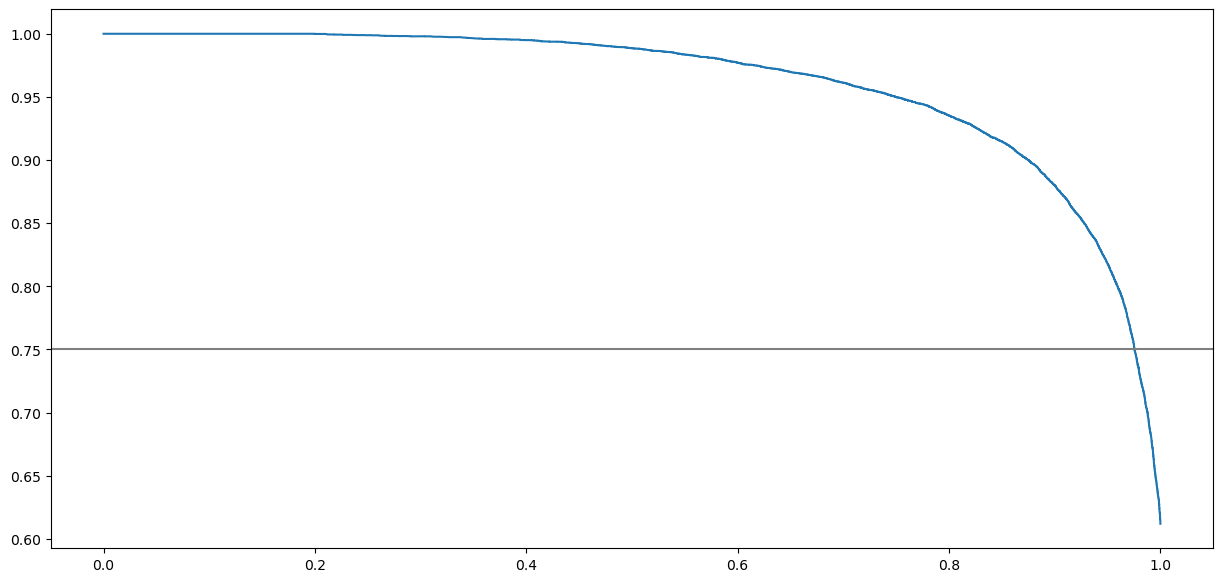

In [10]:
import gc

file_logs_read = DATASET_PATH.joinpath('scores.logs')
file_logs = WORK_PATH.joinpath('scores.logs')

if not file_logs.is_file():
    df = pd.read_csv(file_logs_read, sep=';')
    df.to_csv(file_logs, index=False, sep=';')
else:
    df = pd.read_csv(file_logs, sep=';')

if len(df):
    df.num = df.index + 1
    max_num = df.num.max()
else:    
    max_num = 0

start_time = print_msg('Обучение Catboost классификатор...')

data_cls = DataTransform()

# # небольшая выборка для тестов
# train_df, test_df, data_cls = read_train_test_sample(rebuilding_pairs=True)

# чтение подготовленного датасета
train_df, test_df, dts = read_train_test(rebuilding_pairs=False)

# print(train_df.shape, test_df.shape, set(train_df.columns) - set(test_df.columns),
#       train_df.columns.to_list().index('cat3'))
# print(train_df.columns.to_list())
# print(test_df.columns.to_list())

cam_atrs = sorted(filter(lambda x: re.fullmatch(r'atr_\d+', x), train_df.columns))
fuz_atts = sorted(filter(lambda x: re.fullmatch(r'fuz_atr_\d+', x), train_df.columns))
comp_atrs = sorted(filter(lambda x: re.fullmatch(r'comp_atr_\d+', x), train_df.columns))
keys_atrs = sorted(filter(lambda x: re.fullmatch(r'keys_\d+', x), train_df.columns))

# количество характеристик товара, которые будем использовать: задавать четное число
# было 176
numbers_cam_atrs = 276  # 99 * 2
numbers_fuz_atrs = 276  # 99 * 2
numbers_comp_atrs = 276  # 99 * 2
numbers_keys_atrs = 276  # 99 * 2
# перезапишем словарь из класса dts в класс data_cls
dts.exclude_columns.extend(['pic_emb_mean', 'cam_lemm', 'name_stem_lemm',
                            # 'cam_lm_len',  # эта колонка была в сабмите 207
                            'cos_pics', 'epic'])
dts.exclude_columns.extend(cam_atrs[numbers_cam_atrs:])
dts.exclude_columns.extend(fuz_atts[numbers_fuz_atrs:])
dts.exclude_columns.extend(comp_atrs[numbers_comp_atrs:])
dts.exclude_columns.extend(keys_atrs[numbers_keys_atrs:])

dts.exclude_columns.extend([
    # 'fract_cam_lm_len',  # это было в сабмите 207
    # 'fract_name_lm_len',  # это было в сабмите 207
    # 'fuz_cam_lemm',  # это было в сабмите 207
    # 'fuz_name_lemm',  # это было в сабмите 207
    # 'name_lm_len',  # это было в сабмите 207
    
    # 'fuz_name_stem_lemm', # закоментил это
    
    # это новые колонки были в сабмите 56 - это раскоментарил
    'fract_name_stem_lemm', 
    'frset_cam_stem', 
    'frset_name_lemm',  
    'frset_name_stem', 
    'frset_name_stem_lemm', 
])

dts.category_columns = ['cat3', 'cat31', 'cat32', 'categories', 'color']

# if 'cat3' in dts.exclude_columns:
#     dts.exclude_columns.remove('cat3')

# удаление категорийных колонок, если они есть в исключенных
cat_columns = dts.__dict__['category_columns']
cat_columns = [col for col in cat_columns if col not in dts.exclude_columns]
dts.__dict__['category_columns'] = cat_columns

# cam_atrs_numeric = [*filter(lambda x: str(train_df[x].dtype)[:3] in ('int', 'flo'),
#                             cam_atrs[:numbers_cam_atrs])]
# cam_atrs = [*filter(lambda x: x not in cam_atrs_numeric, cam_atrs[:numbers_cam_atrs])]

data_cls.__dict__ = dts.__dict__.copy()
data_cls.category_columns.extend(['categories', 'categories1', 'categories2'])
data_cls.category_columns.append('cat3_grouped')
# data_cls.category_columns.append('cat3')
data_cls.category_columns.extend(cam_atrs[:numbers_cam_atrs])
data_cls.category_columns.extend(keys_atrs[:numbers_keys_atrs])

# print(train_df.columns.to_list())
# print(data_cls.__dict__)

start_time = print_msg('Постобработка датасетов с парами товаров')
expand_columns = ['main_pic', 'name_bert']
train_df = data_cls.transform(None, train_df, expand_columns=expand_columns)
test_df = data_cls.transform(None, test_df, expand_columns=expand_columns)
train_df = data_cls.add_revers_pairs(train_df, test_df, number_fractions=-999, all_rows=True)
print_time(start_time)

exclude_columns = dts.__dict__['exclude_columns']
exclude_columns.extend([cn for cn in data_cls.exclude_columns if cn not in exclude_columns])

if 'cat32' in train_df.columns:
    train_df.drop('cat32', axis=1, inplace=True)
    test_df.drop('cat32', axis=1, inplace=True)
    exclude_columns.append('cat32')
    if 'cat32' in data_cls.category_columns:
        data_cls.category_columns.remove('cat32')

data_cls.exclude_columns = exclude_columns

cat_columns = data_cls.category_columns
model_columns = train_df.columns.to_list()

print('Обучаюсь на колонках:', model_columns)
print('Категорийные колонки:', cat_columns)
print('Исключенные колонки:', data_cls.exclude_columns)

if 'cat31' in train_df.columns:
    # добавление cat31 для валидации кто попался только один раз
    for cat31 in train_df.cat31.unique():
        if len(train_df.loc[train_df.cat31 == cat31]) < 5:
            print(f'cat31 = {cat31}')
            train_df = train_df.append(train_df.loc[train_df.cat31 == cat31])
            train_df = train_df.append(train_df.loc[train_df.cat31 == cat31])
            train_df = train_df.append(train_df.loc[train_df.cat31 == cat31])
        elif len(train_df.loc[train_df.cat31 == cat31]) < 10:
            print(f'cat31 = {cat31}')
            train_df = train_df.append(train_df.loc[train_df.cat31 == cat31])

    train_df.reset_index(drop=True, inplace=True)

print(f'Размер train_df = {train_df.shape}, test_df = {test_df.shape}')

columns_no_to_model = ['target', 'variantid1', 'variantid2']
trn = train_df[columns_no_to_model + ['cat3_grouped', 'cat31']]
train = train_df.drop(columns_no_to_model, axis=1)
target = train_df['target']

# print(train[cat_columns].dtypes)

# test_sizes = (0.1, 0.14, 0.15, 0.15000000000000002)
# test_sizes = (0.1, 0.12, 0.14, 0.15)
test_sizes = (0.13,)
# test_sizes = (0.1,)
# test_sizes = np.linspace(0.1, 0.4, 4)
# for num_iters in range(50, 151, 50):
# for SEED in range(100):
for test_size in test_sizes:
    # for num_iters in range(200, 901, 50):
    # for num_leaves in range(20, 51, 5):
    max_num += 1

    # test_size = 0.2
    # num_iters = 600
    SEED = 86

    print(f'test_size: {test_size} SEED={SEED}')

    stratify_columns = ['target', 'cat3_grouped']
    # stratify_columns = ['target', 'cat31']

    # Split the train_df into training and testing sets
    X_train, X_valid, y_train, y_valid = train_test_split(train, target,
                                                          test_size=test_size,
                                                          stratify=trn[stratify_columns],
                                                          random_state=SEED)

    pool_train = Pool(data=X_train, label=y_train, cat_features=cat_columns)
    pool_valid = Pool(data=X_valid, label=y_valid, cat_features=cat_columns)
    pool_test = Pool(data=test_df.drop(columns_no_to_model[1:], axis=1),
                     cat_features=cat_columns)


    num_folds = 4
    skf = StratifiedKFold(n_splits=num_folds)
    split_kf = KFold(n_splits=num_folds)

    fit_on_full_train = False
    use_grid_search = False
    use_cv_folds = False
    build_model = True
    stratified = True
    write_log = False

    models, models_scores, predict_scores = [], [], []

    loss_function = 'Logloss'

    auto_class_weights = 'Balanced'
#     auto_class_weights = None

    eval_metric = 'Precision'
#     eval_metric = 'TotalF1'

    clf_params = dict(cat_features=cat_columns,
                      auto_class_weights=auto_class_weights,
                      loss_function=loss_function,
                      eval_metric=eval_metric,
#                       iterations=2000,  # попробовать столько итераций
                      early_stopping_rounds=80,
                      random_seed=SEED,
                      task_type="GPU",
                      devices='0:1',
                      gpu_ram_part=0.93,
                      )

    clf = CatBoostClassifier(**clf_params)

    if use_grid_search:
        # grid_params = {
        #     'max_depth': [5, 6],
        #     'learning_rate': [0.1, 0.15, 0.2],
        # }
        # grid_search_result = clf.grid_search(grid_params, train, target,
        #                                      cv=skf,
        #                                      stratified=True,
        #                                      refit=True,
        #                                      plot=True,
        #                                      verbose=100,
        #                                      )
        # best_params = grid_search_result['params']
        # models.append(clf)

        study = optuna.create_study(
            pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), direction="maximize"
        )
        study.optimize(objective, n_trials=12, timeout=600)

        print("Number of finished trials: {}".format(len(study.trials)))
        print("Best trial:")
        trial = study.best_trial

        print("  Value: {}".format(trial.value))
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))

        best_params = trial.params

        clf_params.update(best_params)
        print('clf_params', clf_params)

        clf = CatBoostClassifier(**clf_params)

    if use_cv_folds:
        if stratified:
            skf_folds = skf.split(train, trn[['target', 'cat3_grouped']])
        else:
            skf_folds = split_kf.split(train)

        for idx, (train_idx, valid_idx) in enumerate(skf_folds, 1):
            print(f'Фолд {idx} из {num_folds}')
            train_data = Pool(data=train.iloc[train_idx],
                              label=target.iloc[train_idx],
                              cat_features=cat_columns)
            valid_data = Pool(data=train.iloc[valid_idx],
                              label=target.iloc[valid_idx],
                              cat_features=cat_columns)
            model = clf
            model.fit(train_data, eval_set=valid_data, use_best_model=True, verbose=100)
            models.append(model)
            if build_model:
                DTS = (X_train, X_valid, y_train, y_valid, train, target, test_df, trn)
                predict_scores = predict_test(idx, clf, DTS, max_num, submit_prefix='cb_')
                models_scores.append(predict_scores)
                acc_train, acc_valid, roc_auc, f1w, score_train, score_valid = predict_scores
                comment = {'test_size': test_size,
                           'SEED': SEED,
                           'size': f'pool_{idx}'}
                comment.update(data_cls.comment)
                comment.update({'stratified': stratify_columns})
                comment.update(clf.get_params())

                with open(file_logs, mode='a') as log:
                    # log.write('num;mdl;roc_auc;acc_train;acc_valid;sc_train;score;WF1;'
                    #           'model_columns;exclude_columns;cat_columns;comment\n')
                    log.write(f'{max_num};cb;{roc_auc:.6f};{acc_train:.6f};{acc_valid:.6f};'
                              f'{score_train:.6f};{score_valid:.6f};{f1w:.6f};'
                              f'{train_df.columns.tolist()};'
                              f'{data_cls.exclude_columns};{cat_columns};{comment}\n')

        best_params = {'iterations': [clf.tree_count_ for clf in models]}

    else:
        DTS = (X_train, X_valid, y_train, y_valid, train, target, test_df, trn)

        clf.fit(pool_train, eval_set=pool_valid, use_best_model=True, verbose=50)

        models.append(clf)

        best_params = {'clf_iters': clf.tree_count_,
                       'clf_lr': clf.get_all_params()['learning_rate']}

        if build_model:
            if not fit_on_full_train:
                predict_scores = predict_test(0, clf, DTS, max_num, submit_prefix='cb_')

            else:
                predict_scores = predict_test('pool', clf, DTS, max_num, submit_prefix='cb_')
                acc_train, acc_valid, roc_auc, f1w, score_train, score_valid = predict_scores
                comment = {'test_size': test_size,
                           'SEED': SEED,
                           'size': 'pool'}
                comment.update(data_cls.comment)
                comment.update({'stratified': stratify_columns})
                comment.update(models[0].get_params())

                with open(file_logs, mode='a') as log:
                    # log.write('num;mdl;roc_auc;acc_train;acc_valid;sc_train;score;WF1;'
                    #           'model_columns;exclude_columns;cat_columns;comment\n')
                    log.write(f'{max_num};lg;{roc_auc:.6f};{acc_train:.6f};{acc_valid:.6f};'
                              f'{score_train:.6f};{score_valid:.6f};{f1w:.6f};'
                              f'{train_df.columns.tolist()};'
                              f'{data_cls.exclude_columns};{cat_columns};{comment}\n')

                # обучение на всем трейне
                print('Обучаюсь на всём трейне...')
                clf_params['iterations'] = int(clf.tree_count_ * 1.1)
                clf_params['learning_rate'] = clf.get_all_params()['learning_rate']
                model = CatBoostClassifier(**clf_params)
                model.fit(train, target, verbose=50, cat_features=cat_columns)
                predict_scores = predict_test('full', model, DTS, max_num,
                                              submit_prefix='cb_')

        elif write_log:
            predict_scores = predict_train_valid(0, clf, DTS, max_num)

        best_params.update(clf.get_params())

    print('best_params:', best_params)

    if build_model or write_log:
        if len(models) > 1:
            predict_scores = [np.mean(arg) for arg in zip(*models_scores)]

        acc_train, acc_valid, roc_auc, f1w, score_train, score_valid = predict_scores

        print(f'Weighted F1-score = {f1w:.6f}')
        print('Параметры модели:', clf.get_params())

        print_time(start_time)

        comment = {'test_size': test_size,
                   'SEED': SEED,
                   'clf_iters': clf.best_iteration_,
                   'clf_lr': clf.get_params().get('learning_rate'),
                   'stratified': stratified}
        comment.update(data_cls.comment)
        comment.update(clf.get_params())

        with open(file_logs, mode='a') as log:
            # log.write('num;mdl;roc_auc;acc_train;acc_valid;sc_train;score;WF1;'
            #           'model_columns;exclude_columns;cat_columns;comment\n')
            log.write(f'{max_num};cb;{roc_auc:.6f};{acc_train:.6f};{acc_valid:.6f};'
                      f'{score_train:.6f};{score_valid:.6f};{f1w:.6f};'
                      f'{train_df.columns.tolist()};'
                      f'{data_cls.exclude_columns};{cat_columns};{comment}\n')

In [13]:
from IPython.display import display, FileLink
from zipfile import ZipFile, ZIP_DEFLATED as ZD
from glob import glob

files = glob(f'{PREDICTIONS_DIR}/*.csv') + glob(f'{PREDICTIONS_DIR}/*.logs')
zip_filename = WORK_PATH.joinpath('predictions.zip')
with ZipFile(zip_filename, 'w',  compression=ZD, compresslevel=9) as zip_file:
    for filename in files:
        print(filename)
        zip_file.write(filename)
FileLink(zip_filename)

./cb_submit_086.csv
./cb_train_086.csv
./scores.logs


/kaggle/working/predictions.zip

In [12]:
gc.collect()

3768